In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from collections import Counter

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import learning_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve


In [2]:
#Python 3.8.12 (default, Oct 12 2021, 06:23:56) 
#[Clang 10.0.0 ] :: Anaconda, Inc. on darwin

#!python - V

## Dask Client Setup

In [3]:
#!pip install dask
#!pip install "dask[distributed]" --upgrade
#!pip install dask_ml
#!pip install numpy==1.20.3

In [4]:
import dask
import dask.distributed
from dask.distributed import Client, LocalCluster

from sklearn.utils import parallel_backend
import joblib

from dask.utils import format_bytes
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

In [5]:
# dask.config.get()

In [6]:
#client.shutdown()

In [7]:
#from dask.distributed import Client

# If you have a remote cluster running Dask

# host = '<ip_address>'

# client = Client(f'tcp://{host}:9999')

# If you want Dask to set itself up on your personal computer

cluster=LocalCluster(n_workers=30, dashboard_address="9999",silence_logs=False)
client = Client(cluster)

#client.dashboard_link

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:46167
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:9999
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:40697'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:36289'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42333'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:43337'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:41319'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:41259'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:40311'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44897'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:35081'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45979'
distributed.nanny - INFO -         Start Nanny at: 'tcp:

In [8]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Dashboard: http://127.0.0.1:9999/status,Workers: 30
Total threads: 60,Total memory: 236.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46167,Workers: 30
Dashboard: http://127.0.0.1:9999/status,Total threads: 60
Started: Just now,Total memory: 236.14 GiB
Comm: tcp://127.0.0.1:38547,Total threads: 2
Dashboard: http://127.0.0.1:42485/status,Memory: 7.87 GiB
Nanny: tcp://127.0.0.1:40311,


In [9]:
X_total = pd.read_csv('X.csv')

y_total = pd.read_csv('y.csv')

y_total = y_total.values.ravel()

In [10]:
sample_size = 100000

X= X_total
y= y_total

X_subsample, _, y_subsample, __ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)

In [11]:
print(len(X_subsample))
print(len(y_subsample))

100000
100000


In [12]:
#redefining X and y to be the 50k stratified subsample

X= X_subsample
y= y_subsample

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

In [13]:
print(len(X_train))
print(len(y_train))

75000
75000


In [14]:
num_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('norm', PowerTransformer(method='yeo-johnson', standardize=True))
])

#BOXCOX TRANSFORM
# num_transform = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
#     ('scale', MinMaxScaler([1,2]))
#     ('norm', PowerTransformer(method='box-cox', standardize=True))])

cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# CONSTANT CAT. IMPUTER
# cat_transform = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
#     ('onehot',OneHotEncoder(handle_unknown='ignore'))
# ])

In [15]:
num_ix = X.select_dtypes(['float64','int64']).columns
cat_ix = X.select_dtypes(['O']).columns

In [16]:
#Build out the column transformer

t= [
    ('categorical',cat_transform,cat_ix),
    ('numerical',num_transform,num_ix),
]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

In [17]:
#Define metric used
F2 = make_scorer(fbeta_score, beta=2)
metric = F2
# metric = 'roc_auc'

## Base RF

In [19]:
%%time

with parallel_backend('dask'):

    model = RandomForestClassifier()

    pipe = Pipeline(steps=[
        ('preprocess',ct),
        ('model', model)
    ])

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    #param_grid = {'model_tune__n_estimators': [100]}
    param_grid = {'model__max_features': ['auto']}

    grid = DaskGridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric) 

    grid_result = grid.fit(X_train, y_train)

    #scores = cross_val_score(grid_result, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)

print(f'Best score:{grid_result.best_score_}')
print(f'Best params:{grid_result.best_params_}')


Best score:0.937455709521307
Best params:{'model__max_features': 'auto'}
CPU times: user 20 s, sys: 5.21 s, total: 25.2 s
Wall time: 1min 5s


In [26]:
# %%time

# with parallel_backend('loky'):

#     model = RandomForestClassifier()

#     pipe = Pipeline(steps=[
#         ('preprocess',ct),
#         ('model', model)
#     ])

#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#     #param_grid = {'model_tune__n_estimators': [100]}
#     param_grid = {'model__max_features': ['auto']}

#     grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric, verbose=1) 

#     grid_result = grid.fit(X_train, y_train)

#     #scores = cross_val_score(grid_result, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)

# print(f'Best score:{grid_result.best_score_}')
# print(f'Best params:{grid_result.best_params_}')

In [20]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

0.937456 (0.008032) with: {'model__max_features': 'auto'}


In [21]:
pred = grid_result.predict(X_test)

conf_matx = confusion_matrix(y_test, pred)

print(conf_matx) 

classif_report = classification_report(y_test,pred,digits=3)

print(classif_report)

[[21728    38]
 [  273  2961]]
              precision    recall  f1-score   support

           0      0.988     0.998     0.993     21766
           1      0.987     0.916     0.950      3234

    accuracy                          0.988     25000
   macro avg      0.987     0.957     0.971     25000
weighted avg      0.988     0.988     0.987     25000



Precision: 0.9876
Recall: 0.9983
AUROC: 0.957


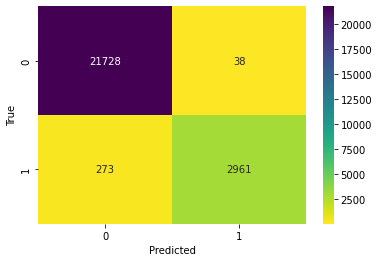

In [22]:
true_pos = conf_matx[0][0]
false_pos = conf_matx[1][0]
true_neg = conf_matx[1][1]
false_neg = conf_matx[0][1]

precision = true_pos/(true_pos + false_pos)

recall = true_pos/(true_pos + false_neg)

auroc = roc_auc_score(y_test,pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUROC: {auroc:.3f}')

ax = sns.heatmap(conf_matx, cmap='viridis_r', annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8706
Random Forest ROC AUC: 0.9569
Best F2 Score: 0.9375


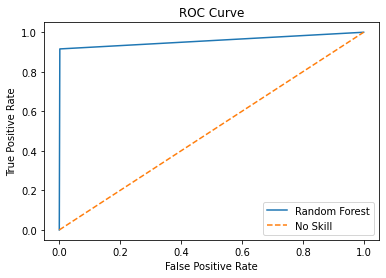

In [23]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_test)[0]/(Counter(y_test)[0]+Counter(y_test)[1]):.4f}')

print(f'Random Forest ROC AUC: {auroc:.4f}')

print(f'Best F2 Score: {grid.best_score_:.4f}')

fpr, tpr, _ = roc_curve(y_test,pred)


plt.plot(fpr,tpr, label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tuned RF

In [24]:
%%time

#DASK

#SKlearn Gridsearch takes 13mins
#DaskGSCV takes 5min 11 seconds without a local cluster (1 worker); similar time with local cluster (4 workers)

with parallel_backend('dask'):

    model_tune = RandomForestClassifier()

    pipe_tune = Pipeline(steps=[
        ('preprocess',ct),
        ('model_tune', model_tune)
    ])

    cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    param_grid_tune = [
        {'model_tune__class_weight': ['balanced','balanced_subsample'],
         'model_tune__n_estimators': [50,100,250],
         'model_tune__max_depth' : [4,8,None],
         'model_tune__max_features': ['sqrt',None]}
         ]

    grid_tune = DaskGridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric) 

    grid_result_tune = grid_tune.fit(X_train, y_train)

    #scores_tune = cross_val_score(grid_result_tune, X_test, y_test, scoring=metric, cv=cv_tune, n_jobs=-1)

print(f'Best score:{grid_result_tune.best_score_}')
print(f'Best params:{grid_result_tune.best_params_}')


/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
distributed.utils_perf - INFO - full garbage collection released 65.92 MiB from 21 reference cycles (threshold: 9.54 MiB)
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
distributed.utils_perf - INFO - full garbage collection released 65.92 MiB from 21 reference cycles (threshold: 9.54 MiB)
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/cxa013

Best score:0.9688708017932134
Best params:{'model_tune__class_weight': 'balanced', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 250}
CPU times: user 22min 5s, sys: 6min 33s, total: 28min 38s
Wall time: 54min 4s


In [25]:
means_tune = grid_result_tune.cv_results_['mean_test_score']
stds_tune = grid_result_tune.cv_results_['std_test_score']
params_tune = grid_result_tune.cv_results_['params']
for mean, stdev, param in zip(means_tune, stds_tune, params_tune):
    print('%f (%f) with: %r' % (mean, stdev, param))

0.866164 (0.017598) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 4, 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 50}
0.873534 (0.014083) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 4, 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 100}
0.873257 (0.012494) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 4, 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 250}
0.889097 (0.007008) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 4, 'model_tune__max_features': None, 'model_tune__n_estimators': 50}
0.888936 (0.006338) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 4, 'model_tune__max_features': None, 'model_tune__n_estimators': 100}
0.889318 (0.006950) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 4, 'model_tune__max_features': None, 'model_tune__n_estimators': 250}
0.919024 (0.007793) with

In [131]:
pd.DataFrame(data=[means_tune,stds_tune,params_tune]).transpose().sort_values(by=0,ascending=False).head(10)

,0,1,2
17,0.968871,0.004775,"{'model_tune__class_weight': 'balanced', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 250}"
35,0.968593,0.004584,"{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 250}"
16,0.968553,0.004842,"{'model_tune__class_weight': 'balanced', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 100}"
34,0.968171,0.005012,"{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 100}"
33,0.967619,0.004976,"{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 50}"
15,0.967394,0.004959,"{'model_tune__class_weight': 'balanced', 'model_tune__max_depth': None, 'model_tune__max_features': None, 'model_tune__n_estimators': 50}"
27,0.956007,0.005201,"{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_depth': 8, 'model_tune__max_features': None, 'model_tune__n_estimators': 50}"
29,0.95593,0.005269,"{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_depth': 8, 'model_tune__max_features': None, 'model_tune__n_estimators': 250}"
11,0.955866,0.005607,"{'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 8, 'model_tune__max_features': None, 'model_tune__n_estimators': 250}"
10,0.955664,0.005569,"{'model_tune__class_weight': 'balanced', 'model_tune__max_depth': 8, 'model_tune__max_features': None, 'model_tune__n_estimators': 100}"


In [26]:
pred_tune = grid_result_tune.predict(X_test)

conf_matx_tune = confusion_matrix(y_test, pred_tune)

print(conf_matx_tune) 

classif_report_tune = classification_report(y_test,pred_tune,digits=3)

print(classif_report_tune)

[[21745    21]
 [  127  3107]]
              precision    recall  f1-score   support

           0      0.994     0.999     0.997     21766
           1      0.993     0.961     0.977      3234

    accuracy                          0.994     25000
   macro avg      0.994     0.980     0.987     25000
weighted avg      0.994     0.994     0.994     25000



Precision: 0.9942
Recall: 0.9990
AUROC: 0.980


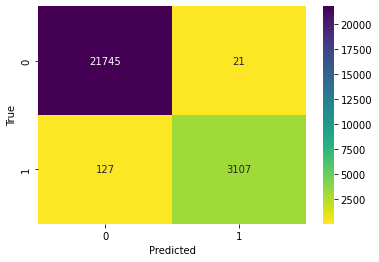

In [28]:
true_pos_tune = conf_matx_tune[0][0]
false_pos_tune = conf_matx_tune[1][0]
true_neg_tune = conf_matx_tune[1][1]
false_neg_tune = conf_matx_tune[0][1]

precision_tune = true_pos_tune/(true_pos_tune + false_pos_tune)

recall_tune = true_pos_tune/(true_pos_tune + false_neg_tune)

auroc_tune = roc_auc_score(y_test,pred_tune)

print(f'Precision: {precision_tune:.4f}')
print(f'Recall: {recall_tune:.4f}')
print(f'AUROC: {auroc_tune:.3f}')

ax_tune = sns.heatmap(conf_matx_tune, cmap='viridis_r', annot=True, fmt='d')
ax_tune.set_xlabel('Predicted')
ax_tune.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8706
Random Forest ROC AUC: 0.9799
Best F2 Score: 0.9689


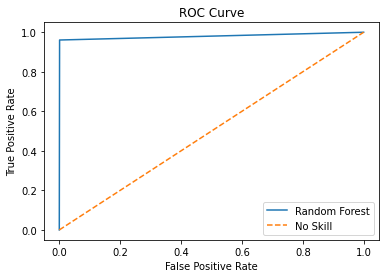

In [29]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_test)[0]/(Counter(y_test)[0]+Counter(y_test)[1]):.4f}')

print(f'Random Forest ROC AUC: {auroc_tune:.4f}')

print(f'Best F2 Score: {grid_tune.best_score_:.4f}')

fpr_tune, tpr_tune, _ = roc_curve(y_test,pred_tune)

plt.plot(fpr_tune,tpr_tune, label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Learning Curves

In [24]:
sample_size_learn = 200000

X= X_total
y= y_total

X_learn, _, y_learn, __ = train_test_split(X, y, train_size=sample_size_learn, stratify=y, random_state=42)

In [25]:
%%time

pipe_learn = Pipeline(steps=[
    ('preprocess',ct),
    ('model_learn', RandomForestClassifier(class_weight = 'balanced', max_depth=None, max_features=None, n_estimators=100))
])

#cv_learn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
with parallel_backend('dask'):
    pipe_learn.fit(X_learn, y_learn)


distributed.scheduler - INFO - Receive client connection: Client-worker-fd974772-4761-11ec-b183-cfd139b90965
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-fdb8777d-4761-11ec-add8-cfd139b90965
distributed.core - INFO - Starting established connection
distributed.utils - ERROR - 'batch_of__fit_transform_one_1_calls'
Traceback (most recent call last):
  File "/home/cxa013/.local/lib/python3.8/site-packages/distributed/utils.py", line 648, in log_errors
    yield
  File "/home/cxa013/.local/lib/python3.8/site-packages/distributed/dashboard/components/scheduler.py", line 2294, in update_layout
    order = dask.order.order(
  File "/home/cxa013/.local/lib/python3.8/site-packages/dask/order.py", line 116, in order
    metrics = graph_metrics(dependencies, dependents, total_dependencies)
  File "/home/cxa013/.local/lib/python3.8/site-packages/dask/order.py", line 886, in graph_metrics
    val = total_dependenci

CPU times: user 15.9 s, sys: 3.14 s, total: 19 s
Wall time: 49 s


In [26]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    with parallel_backend('dask'):
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
            estimator,
            X,
            y,
            cv=cv,
            n_jobs=n_jobs,
            scoring = metric,
            train_sizes=train_sizes,
            return_times=True,
        )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

distributed.utils_perf - INFO - full garbage collection released 243.20 MiB from 326 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 83.04 MiB from 85 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 200.16 MiB from 147 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 200.14 MiB from 64 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 268.14 MiB from 176 reference cycles (threshold: 9.54 MiB)
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
distributed

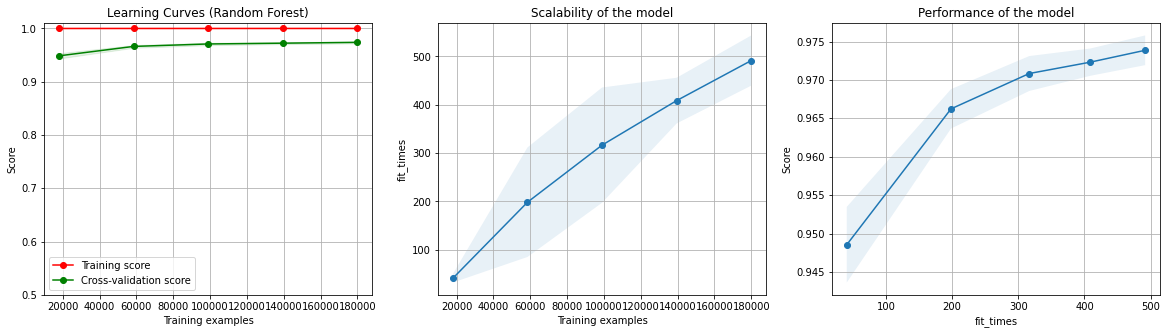

CPU times: user 4min 33s, sys: 53.1 s, total: 5min 26s
Wall time: 9min 11s


In [27]:
%%time

# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Random Forest)"

cv_learn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

estimator = pipe_learn

with parallel_backend('dask'):
    plot_learning_curve(
        estimator, title, X_learn, y_learn, ylim=(0.5, 1.01), cv=cv_learn, n_jobs=-1
    )
    
    plt.show()

In [29]:
sample_size_learn = 300000

X= X_total
y= y_total

X_learn_large, _, y_learn_large, __ = train_test_split(X, y, train_size=sample_size_learn, stratify=y, random_state=42)

distributed.utils_perf - INFO - full garbage collection released 97.03 MiB from 1585 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 77.07 MiB from 1797 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 117.05 MiB from 1800 reference cycles (threshold: 9.54 MiB)
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
distributed.utils_perf - INFO - full garbage collection released 73.59 MiB from 1718 reference cycles (threshold: 9.54 MiB)
distributed.utils_perf - INFO - full garbage collection released 347.35 MiB from 1213 reference cycles (threshold: 9.54 MiB)
/home/

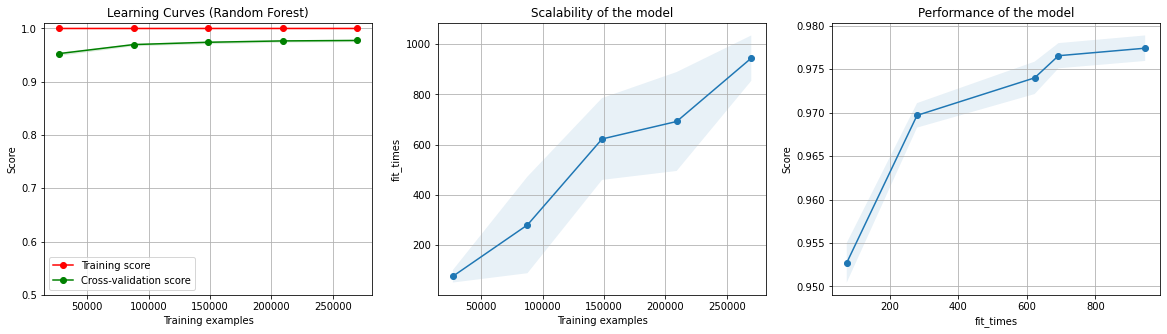

CPU times: user 8min 20s, sys: 1min 34s, total: 9min 54s
Wall time: 18min 44s


In [30]:
%%time

# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Random Forest)"

cv_learn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

estimator = pipe_learn

with parallel_backend('dask'):
    plot_learning_curve(
        estimator, title, X_learn_large, y_learn_large, ylim=(0.5, 1.01), cv=cv_learn, n_jobs=-1
    )
    
    plt.show()

## Feature Importance (Base Model)

In [33]:
feature_import = grid_result.best_estimator_._final_estimator.feature_importances_

In [34]:
#Get feature names
feat_fit = pipe.fit(X_train, y_train)
onehot_cat_cols = feat_fit.named_steps['preprocess'].transformers_[0][1].named_steps['onehot'].get_feature_names(cat_ix)

onehot_cat_cols = list(onehot_cat_cols)

features = list(onehot_cat_cols)
features.extend(num_ix)

/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
feat_count = 25

feature_importance = pd.Series(index=features, data=feature_import).nlargest(feat_count)
feature_importance

last_fico_range_high      0.199534
last_fico_range_low       0.142113
total_rec_prncp           0.102678
last_pymnt_amnt           0.075569
last_pymnt_d_rel          0.072027
total_pymnt               0.039999
last_credit_pull_d_rel    0.033911
out_prncp                 0.032615
funded_amnt               0.026553
loan_amnt                 0.025174
installment               0.024550
issue_d_rel               0.020236
total_rec_int             0.014307
total_rec_late_fee        0.011233
int_rate                  0.009714
grade_ord                 0.008146
term                      0.006799
dti                       0.005236
revol_bal                 0.004828
bc_open_to_buy            0.004748
total_bc_limit            0.004656
annual_inc                0.004524
total_rev_hi_lim          0.004518
mo_sin_old_rev_tl_op      0.004492
revol_util                0.004431
dtype: float64

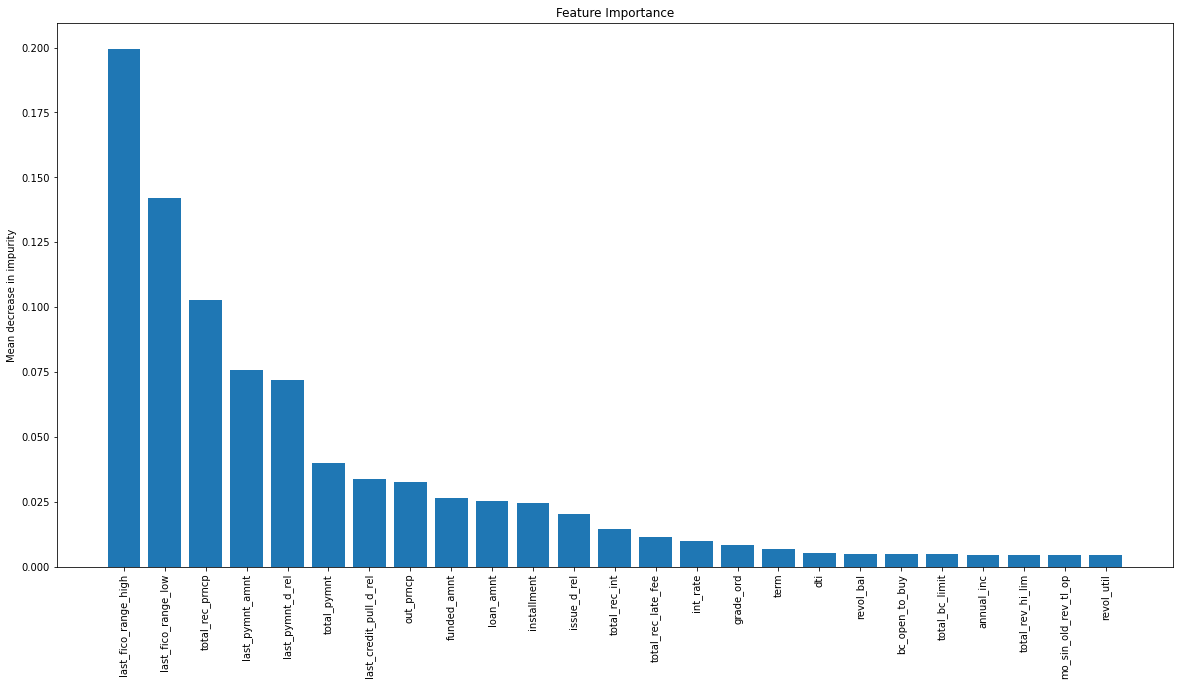

In [36]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance.index,feature_importance.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [37]:
eli5.explain_weights(grid_result.best_estimator_['model'], top=feat_count, feature_names = features)

Weight,Feature
0.1995 ± 0.2788,last_fico_range_high
0.1421 ± 0.2559,last_fico_range_low
0.1027 ± 0.1229,total_rec_prncp
0.0756 ± 0.0745,last_pymnt_amnt
0.0720 ± 0.0927,last_pymnt_d_rel
0.0400 ± 0.0367,total_pymnt
0.0339 ± 0.0882,last_credit_pull_d_rel
0.0326 ± 0.0568,out_prncp
0.0266 ± 0.0375,funded_amnt
0.0252 ± 0.0333,loan_amnt


In [38]:
pd.set_option('display.max_colwidth', None)
definitions = pd.read_csv('LoanStats.csv')

In [39]:
for i in feature_importance.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

38    The lower boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

109    Principal received to date
Name: Description, dtype: object

39    Last total payment amount received
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

105    Payments received to date for total amount funded
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Name: Description, dtype: object

33    The monthly payment owed by the borrow

## Feature Importance (Tuned Model)

In [41]:
feature_import_tune = grid_result_tune.best_estimator_._final_estimator.feature_importances_

In [42]:
grid_result_tune.best_estimator_._final_estimator.feature_importances_

array([6.55283918e-07, 4.22315822e-05, 1.25265530e-20, 8.69013286e-05,
       5.40243584e-05, 5.71778890e-05, 6.49041218e-05, 4.03949437e-05,
       2.40618761e-04, 1.64935182e-04, 6.42169826e-05, 5.39530886e-05,
       3.51655104e-05, 1.06369468e-05, 9.43481758e-04, 5.85542425e-04,
       3.65126202e-05, 5.52947373e-06, 1.87625259e-02, 3.51756000e-02,
       2.54805839e-04, 1.12971762e-03, 7.58741051e-03, 2.97992689e-04,
       7.86082860e-04, 1.16883940e-03, 3.68169792e-04, 0.00000000e+00,
       0.00000000e+00, 2.74764399e-04, 3.29541564e-04, 1.22485417e-04,
       6.87462710e-04, 7.86070665e-04, 4.11747897e-04, 8.58881114e-03,
       1.53457874e-03, 7.02502685e-02, 2.02795536e-03, 1.92651446e-02,
       9.24134932e-02, 6.23090894e-01, 1.09722453e-02, 4.40821222e-05,
       1.67520280e-05, 4.52252905e-04, 4.25049251e-04, 8.76846977e-04,
       3.36581532e-04, 7.18855203e-04, 1.19309594e-03, 6.53186481e-04,
       1.88693720e-05, 1.21205702e-05, 7.69428359e-04, 9.88961330e-04,
      

In [43]:
#Get feature names
feat_fit_tune = pipe_tune.fit(X_train, y_train)
onehot_cat_cols_tune = feat_fit_tune.named_steps['preprocess'].transformers_[0][1].named_steps['onehot'].get_feature_names(cat_ix)

onehot_cat_cols_tune = list(onehot_cat_cols_tune)

features_tune = list(onehot_cat_cols_tune)
features_tune.extend(num_ix)

/home/cxa013/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/cxa013/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
feature_importance_tune = pd.Series(index=features_tune, data=feature_import_tune).nlargest(feat_count)
feature_importance_tune

last_fico_range_high      0.623091
last_pymnt_amnt           0.092413
last_pymnt_d_rel          0.078348
total_rec_prncp           0.070250
funded_amnt               0.035176
total_rec_late_fee        0.019265
loan_amnt                 0.018763
last_fico_range_low       0.010972
out_prncp                 0.008589
installment               0.007587
total_rec_int             0.002028
total_pymnt               0.001535
last_credit_pull_d_rel    0.001515
issue_d_rel               0.001307
bc_open_to_buy            0.001193
dti                       0.001169
int_rate                  0.001130
total_bc_limit            0.001048
mo_sin_old_rev_tl_op      0.000989
hardship_flag_N           0.000943
total_rev_hi_lim          0.000877
annual_inc                0.000786
revol_util                0.000786
mo_sin_old_il_acct        0.000769
avg_cur_bal               0.000719
dtype: float64

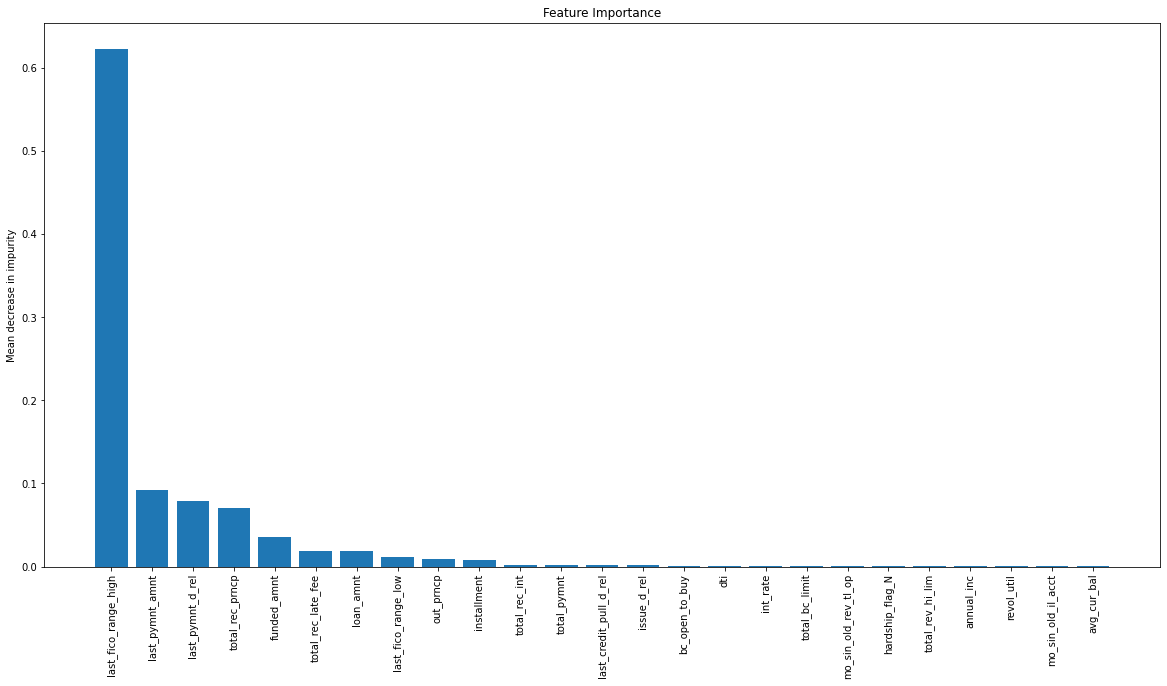

In [45]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance_tune.index,feature_importance_tune.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [46]:
eli5.explain_weights(grid_result_tune.best_estimator_['model_tune'], top=feat_count, feature_names = features_tune)

Weight,Feature
0.6231 ± 0.0212,last_fico_range_high
0.0924 ± 0.0090,last_pymnt_amnt
0.0783 ± 0.0152,last_pymnt_d_rel
0.0703 ± 0.0179,total_rec_prncp
0.0352 ± 0.0232,funded_amnt
0.0193 ± 0.0043,total_rec_late_fee
0.0188 ± 0.0180,loan_amnt
0.0110 ± 0.0199,last_fico_range_low
0.0086 ± 0.0048,out_prncp
0.0076 ± 0.0083,installment


In [47]:
for i in feature_importance_tune.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

39    Last total payment amount received
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

109    Principal received to date
Name: Description, dtype: object

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

108    Late fees received to date
Name: Description, dtype: object

41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Name: Description, dtype: object

38    The lower boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

33    The monthly payment owed by the borrower if the loan originates.
Name: Description, dtype: object

107    I

## Save Model

### Pickle

In [49]:
import pickle

filename = 'trained_rf.sav'

pickle.dump(grid_result_tune, open(filename, 'wb'))

In [50]:
#RandomForestClassifier(class_weight='balanced_subsample', max_features=None, n_estimators=250)

grid_result_tune.best_estimator_._final_estimator

RandomForestClassifier(class_weight='balanced', max_features=None,
                       n_estimators=250)

In [51]:
loaded_model = pickle.load(open(filename, 'rb'))

In [52]:
loaded_model.score(X_test, y_test)

0.9670692231075696

In [53]:
pd.Series(loaded_model.predict(X_test)).to_frame().value_counts()

0    21872
1     3128
dtype: int64

In [54]:
confusion_matrix(y_test, loaded_model.predict(X_test))

array([[21745,    21],
       [  127,  3107]])

### Joblib

In [55]:
joblib.dump(grid_tune, 'joblib_trained_rf.pkl')

['joblib_trained_rf.pkl']

In [56]:
jl_loaded_model = joblib.load('joblib_trained_rf.pkl')

In [57]:
jl_loaded_model.score(X_test, y_test)

0.9670692231075696

# END